In [31]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import cv2
import math

In [2]:
h = 64       # height
w  = 256     # width

In [3]:
clean_data = []
path1 = '/home/evren/classified_data/clean_data/clean_data/'
files = os.listdir(path1)
for i in tqdm(files):
    img = cv2.imread(path1+i,0)   # change 0 to 1 for images
    img = cv2.resize(img,(h,w))
    clean_data.append(img_to_array(img))

100%|██████████| 69071/69071 [00:14<00:00, 4644.32it/s]


In [4]:
noisy_data = []
path2 = '/home/evren/classified_data/noisy_data/15dB/15dB/'
files = os.listdir(path2)
for i in tqdm(files):
    img = cv2.imread(path2+i,0)   # change 0 to 1 for images
    img = cv2.resize(img,(h,w))
    noisy_data.append(img_to_array(img))

100%|██████████| 69071/69071 [00:14<00:00, 4805.56it/s]


In [5]:
noisy_train = np.reshape(noisy_data, (len(noisy_data), h, w, 1))
noisy_train = noisy_train.astype('float32') / 255.

clean_train = np.reshape(clean_data, (len(clean_data), h, w, 1))
clean_train = clean_train.astype('float32') / 255.

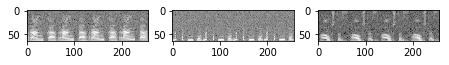

In [6]:
# Displaying images with noise
plt.figure(figsize=(10,2))
for i in range(1,4):
    ax = plt.subplot(1,4,i)
    plt.imshow(noisy_train[i].reshape(h,w), cmap='binary')
plt.show()

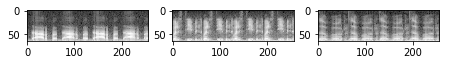

In [7]:
# Displaying images with noise
plt.figure(figsize=(10,2))
for i in range(1,4):
    ax = plt.subplot(1,4,i)
    plt.imshow(clean_train[i].reshape(h,w), cmap='binary')
plt.show()

In [8]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(h,w,1)))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Conv2D(8, (3,3), activation='relu', padding='same'))

model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(8, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 256, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 128, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 8)        2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 8)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 8)          5

In [9]:
x_train, x_test, y_train, y_test = train_test_split(noisy_train, clean_train,
                                                   test_size = 0.20, random_state = 0)

In [10]:
model.fit(x_train, y_train, epochs=10, batch_size=8, shuffle=True, verbose=1, 
         validation_split= 0.1)

Train on 49730 samples, validate on 5526 samples
Epoch 1/10
49730/49730 [==============================] - 584s 12ms/sample - loss: 0.0194 - accuracy: 7.5898e-06 - val_loss: 0.0187 - val_accuracy: 7.3781e-06
Epoch 2/10
49730/49730 [==============================] - 581s 12ms/sample - loss: 0.0187 - accuracy: 7.5959e-06 - val_loss: 0.0186 - val_accuracy: 7.3781e-06
Epoch 3/10
49730/49730 [==============================] - 582s 12ms/sample - loss: 0.0186 - accuracy: 7.5972e-06 - val_loss: 0.0186 - val_accuracy: 7.3781e-06
Epoch 4/10
49730/49730 [==============================] - 585s 12ms/sample - loss: 0.0186 - accuracy: 7.5972e-06 - val_loss: 0.0186 - val_accuracy: 7.3781e-06
Epoch 5/10
49730/49730 [==============================] - 582s 12ms/sample - loss: 0.0186 - accuracy: 7.5959e-06 - val_loss: 0.0186 - val_accuracy: 7.3781e-06
Epoch 6/10
49730/49730 [==============================] - 580s 12ms/sample - loss: 0.0185 - accuracy: 7.5984e-06 - val_loss: 0.0186 - val_accuracy: 7.3781e-

In [15]:
print('Test_Accuracy: {:.2f}%'.format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))

13815/13815 [==============================] - 34s 2ms/sample - loss: 0.0185 - accuracy: 7.4709e-06
Test_Accuracy: 0.00%


In [16]:
model.save('denoising_autoencoder.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: denoising_autoencoder.model/assets


In [17]:
no_noise_img = model.predict(x_test)

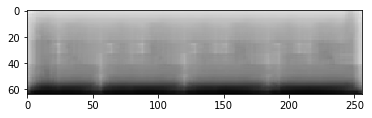

In [18]:
plt.imshow(no_noise_img[i].reshape(h,w), cmap='gray')

In [37]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse)) 
    return psnr

In [38]:
n = 10

for i in range(n):
    
    value = PSNR(x_test[i], no_noise_img[i]) 
    print('PSNR value is {0}'.format(value))

PSNR value is 67.7763589024
PSNR value is 67.5276052782
PSNR value is 66.0935281849
PSNR value is 68.3446755228
PSNR value is 64.9326551918
PSNR value is 65.0084786125
PSNR value is 68.2576263312
PSNR value is 69.341154381
PSNR value is 66.920935192
PSNR value is 67.6933351985
